# MBTI - 16 Personalities classifier

# Introduction to the problem
Design and implement a model that given a "post" as input returns the most suited **Myers-Briggs personality type indicator (MBTI)**.

## What is a MBTI
The MBTI (Myers-Briggs Personality Type Indicator) divides everyone into **16 distinct personality** types across **4 axis**:

* Introversion (**I**) – Extroversion (**E**)
* Intuition (**N**) – Sensing (**S**)
* Thinking (**T**) – Feeling (**F**)
* Judging (**J**) – Perceiving (**P**)

This system is used in: *businesses, online, for fun, for research and lots more*.

# Importing Spark (and some other cool things)
Python's imports

In [0]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sparknlp
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [0]:
from sparknlp.base import *
from sparknlp.annotator import *              
from sparknlp.pretrained import *

import sparknlp
sparknlp.start()

Out[2]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

# MBTI Dataset

## Downloading the dataset onto the cluster

I hosted the dataset on my [github](https://github.com/edu-rinaldi/MBTI-Predictor/blob/main/dataset/mbti_1.csv.zip), so that I and whoever want to train a different model can download it in an easier way.

In [0]:
%sh wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv

### Moving dataset to DBFS

In [0]:
dbutils.fs.mv("file:/tmp/mbti_1.csv", "/FileStore/datasets/")

## Initial dataset analysis

Now that we have downloaded the dataset, let's read it and analyze it

In [0]:
mbti_df = spark.read.load("dbfs:/FileStore/datasets/mbti_1.csv", format="csv", sep=",", inferSchema="true", header="true")
mbti_df.show()

+----+--------------------+
type| posts|
+----+--------------------+
INFJ|'http://www.youtu...|
ENTP|'I'm finding the ...|
INTP|'Good one _____ ...|
INTJ|'Dear INTP, I e...|
ENTJ|'You're fired.|||...|
INTJ|'18/37 @.@|||Scie...|
INFJ|'No, I can't draw...|
INTJ|'I tend to build ...|
INFJ|I'm not sure, tha...|
INTP|'https://www.yout...|
INFJ|'One time my pare...|
ENFJ|'https://www.yout...|
INFJ|'Joe santagato - ...|
INTJ|'Fair enough, if ...|
INTP|'Basically this.....|
INTP|'Your comment scr...|
INFJ|'some of these bo...|
INFP|'I think we do ag...|
INFJ|'I fully believe ...|
INFP|'That's normal, i...|
+----+--------------------+
only showing top 20 rows

### Description of the dataset
This **dataset** contains over **8600 rows of data**, and on each row contains:
* **Type**: 4 letter MBTI code/type
* **Posts**: A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

So after splitting each post we will have about **430k rows**. 

**Acknowledgements:**
This data was collected through the PersonalityCafe forum, as it provides a large selection of people and their MBTI personality type, as well as what they have written.

In [0]:
print(f"The dataset is composed by {len(mbti_df.columns)} columns and {mbti_df.count()} entries/records")

### Splitting posts by "|||" string and lowering "type"

In [0]:
#mbti_splitted_df = mbti_df.select(explode(split("posts", "\|\|\|")).alias("post"), lower("type").alias("type"))
mbti_splitted_df = mbti_df.select(regexp_replace(col('posts'), "\|\|\|", " ").alias("post"), lower("type").alias("type")).withColumn('num_post', lit(50))
mbti_splitted_df.show()

+--------------------+----+--------+
 post|type|num_post|
+--------------------+----+--------+
'http://www.youtu...|infj| 50|
'I'm finding the ...|entp| 50|
'Good one _____ ...|intp| 50|
'Dear INTP, I e...|intj| 50|
'You're fired. Th...|entj| 50|
'18/37 @.@ Scienc...|intj| 50|
'No, I can't draw...|infj| 50|
'I tend to build ...|intj| 50|
I'm not sure, tha...|infj| 50|
'https://www.yout...|intp| 50|
'One time my pare...|infj| 50|
'https://www.yout...|enfj| 50|
'Joe santagato - ...|infj| 50|
'Fair enough, if ...|intj| 50|
'Basically this.....|intp| 50|
'Your comment scr...|intp| 50|
'some of these bo...|infj| 50|
'I think we do ag...|infp| 50|
'I fully believe ...|infj| 50|
'That's normal, i...|infp| 50|
+--------------------+----+--------+
only showing top 20 rows

## Are we dealing with a (Un)balanced Dataset ? 
One of the first things to check is the "density" of each class. 
A balanced dataset makes things easier..

### Counting records for each class

In [0]:
def count_class_instances(df, labelCol, toPandas=True):
  counted_df = df.select(labelCol).groupBy(labelCol).count().sort(labelCol)
  return counted_df.toPandas() if toPandas else counted_df

In [0]:
# Sorting by type because then we could compare this df with another
counted_mbti_types_pdf = count_class_instances(mbti_splitted_df, 'type')
counted_mbti_types_pdf.plot.bar(x='type', y='count', figsize=(15,5), legend=False, color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))

The first thing that unfortunately we can notice is that the dataset is very **unbalanced**.

The most predominant types are **INxx**, which correspond to introvert personalities; this make me think that on internet (especially on forums and/or social networks) the most predominant personality is the introvert one, so in real world application the model could deal more frequently with **INxx** types.

Another thing to notice is that **Sensing** (**xSxx**) personalities are the less frequents, and that is due to the fact that *Sensors* prefer learning information that they can tangibly apply to their lives. 

But to train in a balanced way our model we must find and then apply some strategies for handling this situation.

## Strategies for dealing with this unbalanced dataset
To deal with this situation we have different options:
1. **Undersampling**: remove instances from most frequent classes until the dataset is balanced
2. **Oversampling**: add synthetical instances of less frequent classes
3. **Collect more data**: we can collect more data of less frequent classes

In this notebook first and third strategies will be applied.

First we will undersample our current dataset so at the end It will be balanced, then using a Reddit scraper that I created, we can scrap new data and so we can create a **new dataset** (that will be presented in the next section) for increasing in a balanced way our "final" dataset size.

At first glance you might think of balancing the dataset only by adding new instances taking them from the new dataset but this could lead to several problems.

The two datasets that we are going to "merge" contain data collected from different "environments" (*PersonalityCafe* for the first one, *Reddit* for the second one), so adding the new data only on the less frequent classes can create differences that the model could interpret and use for classification (wrong, because they are not differences given by the class of the instance, but rather by the environment from which the data were collected)

### Additional strategy: divide type in 4 indicators
Dividing type in 4 indicator ("I/E", "N/S", "T/F", "P/J") brings us different benefits:
1. We can create 4 different models (one for each type indicator), so each model could be optimized for its own target (its own type indicator)
2. We can have 4 different datasets, each one with its own different data. For example in the original dataset if we undersample "INTP" instances because of the N value for "N/S" type indicator, we will undersample also information about the other 3 type indicators values

So the idea is to have at the end 4 different Binary Classifier, and then we can "merge" their results for the "final result"

In [0]:
def split_type(df, typeCol='type', withDrop=False):
  indicators = ['ie', 'ns', 'tf', 'pj']
  splitted_type_df = df
  for i, ind in enumerate(indicators):
    splitted_type_df = splitted_type_df.withColumn(ind, substring(typeCol, i+1, 1))
  if withDrop:
    splitted_type_df = splitted_type_df.drop(typeCol) 
  return splitted_type_df, indicators

In [0]:
mbti_type_splitted_df, indicators = split_type(mbti_splitted_df, withDrop=True)
mbti_type_splitted_df = mbti_type_splitted_df.cache()
mbti_type_splitted_df.show()

+--------------------+--------+---+---+---+---+
 post|num_post| ie| ns| tf| pj|
+--------------------+--------+---+---+---+---+
'http://www.youtu...| 50| i| n| f| j|
'I'm finding the ...| 50| e| n| t| p|
'Good one _____ ...| 50| i| n| t| p|
'Dear INTP, I e...| 50| i| n| t| j|
'You're fired. Th...| 50| e| n| t| j|
'18/37 @.@ Scienc...| 50| i| n| t| j|
'No, I can't draw...| 50| i| n| f| j|
'I tend to build ...| 50| i| n| t| j|
I'm not sure, tha...| 50| i| n| f| j|
'https://www.yout...| 50| i| n| t| p|
'One time my pare...| 50| i| n| f| j|
'https://www.yout...| 50| e| n| f| j|
'Joe santagato - ...| 50| i| n| f| j|
'Fair enough, if ...| 50| i| n| t| j|
'Basically this.....| 50| i| n| t| p|
'Your comment scr...| 50| i| n| t| p|
'some of these bo...| 50| i| n| f| j|
'I think we do ag...| 50| i| n| f| p|
'I fully believe ...| 50| i| n| f| j|
'That's normal, i...| 50| i| n| f| p|
+--------------------+--------+---+---+---+---+
only showing top 20 rows

### Single type indicator analysis

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 10))
fig.tight_layout()

axes_idx = {'ie': (0,0), 'ns':(0,1), 'tf':(1,0), 'pj':(1,1)}
for ind in indicators:
  count_class_instances(mbti_type_splitted_df, ind).plot.bar(ax=axes[axes_idx[ind]],\
                                                             subplots=True,\
                                                             x=ind,\
                                                             y='count',\
                                                             legend=False,\
                                                             color=plt.cm.Paired(np.arange(2)))

As we said before the two most unbalanced type indicators are: **"I/E"** and **"N/S"**

# Reddit dataset

It's a **JSONL** dataset containing on each row:
* **Type**: as the MBTI dataset
* **Post**: w.r.t MBTI dataset each line contain a single post

Data has been collected on Reddit using a scraper created by me (code available [here](https://github.com/edu-rinaldi/MBTI-Predictor/tree/main/scraper)).
First thing I collected a list of users (and their respective personality) in 17 subreddits about MBTI ("r/mbti", "r/infp", ...); the personality information is given by a badge that is assigned to the user (and I scraped).

Then, I've scraped the most recent posts of each user (max. 100 for each user) on the **ENTIRE** Reddit platform, so I scraped also posts not related to MBTI.
At the end for each post I assigned the badge (so the personality) related to the author.

## Downloading the dataset

In [0]:
%sh wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/categorized_posts.tar.gz;
tar xvzf /tmp/categorized_posts.tar.gz -C /tmp/

### Move it to DBFS

In [0]:
# Move it to DBFS
dbutils.fs.mv("file:/tmp/categorized_posts_v2.json", "/FileStore/datasets/")

### Loading dataset into a Spark dataframe

In [0]:
#reddit_df = spark.read.json("dbfs:/FileStore/datasets/reddit_mbti.json")
reddit_df = spark.read.load("dbfs:/FileStore/datasets/reddit_mbti.parquet")
# reddit_grouped_df = reddit_df.groupBy('redditor_id', 'type', 'text_type').agg(count(col('redditor_id')).alias('num_post'), concat_ws(" ||| ", collect_list("post")).alias('post')).where(col('num_post') >= 50).cache()

In [0]:
reddit_grouped_df.write.save("dbfs:/FileStore/datasets/reddit_mbti.parquet")

In [0]:
print(f"The dataset is composed by {len(reddit_df.columns)} columns and {reddit_df.count()} entries/records")

The dataset is composed by 5 columns and 5754 entries/records

## Analysis

### Counting records for each type

In [0]:
counted_reddit_types_pdf = count_class_instances(reddit_df, 'type')

fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(15,10))
fig.tight_layout()

counted_mbti_types_pdf.plot.bar(ax=axes[0], subplots=True, x='type', y='count', legend=False, color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))
counted_reddit_types_pdf.plot.bar(ax=axes[1], subplots=True, x='type', y='count', legend=False, color=plt.cm.Paired(np.arange(len(counted_reddit_types_pdf))))

On top we have the MBTI dataset, below we have the Reddit dataset.
As we can see the type distribution is very similar.

### Split type in 4 indicators

In [0]:
reddit_splitted_df, _ = split_type(reddit_df, withDrop=True)
reddit_splitted_df.show()

+-----------+---------+--------+--------------------+---+---+---+---+
redditor_id|text_type|num_post| post| ie| ns| tf| pj|
+-----------+---------+--------+--------------------+---+---+---+---+
 10aaboz1| comment| 100|If he’s trying yo...| i| n| f| p|
 10gpeo| post| 65|1. Wash
2. Dry
3....| e| s| t| p|
 10jzuu| title| 75|Little Blue Heron...| i| n| f| j|
 114mu2| title| 95|Free Meals ||| Th...| e| n| f| p|
 115fn2qo| comment| 100|SAT has trick que...| i| n| t| j|
 11ijcy8| comment| 90|All the animal su...| i| s| t| p|
 12hi70| title| 54|He very rarely lo...| i| s| f| j|
 12j8rw| comment| 100|Also the Punisher...| i| s| f| j|
 12rfvb| post| 57|here are the MOTH...| i| s| t| j|
 12u2t3| comment| 100|I could watch thi...| i| n| t| p|
 13dyu6| comment| 100|What's the crazie...| i| n| f| p|
 14izp5| comment| 100|ESH. Your brothe...| i| n| t| j|
 153ecn| comment| 100|The President set...| i| s| f| j|
 15j9hocw| post| 52|* **READ MORE:**
...| i| s| f| j|
 15weft| comment| 100|Yes but then also...| i| s| t| p|
 163697| comment| 100|That is EXACTLY w...| e| n| t| j|
 163fg2| title| 88|What in segwaytio...| e| n| f| p|
 16v8htmn| title| 98|cursed stylus |||...| i| n| t| j|
 173pra| comment| 100|It’s gonna be fir...| i| s| f| j|
 176b5f| comment| 99|MY CAT STEPPED ON...| i| s| t| j|
+-----------+---------+--------+--------------------+---+---+---+---+
only showing top 20 rows

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 10))
fig.tight_layout()

axes_idx = {'ie': (0,0), 'ns':(0,1), 'tf':(1,0), 'pj':(1,1)}
for ind in indicators:
  count_class_instances(reddit_splitted_df, ind).plot.bar(ax=axes[axes_idx[ind]],\
                                                             subplots=True,\
                                                             x=ind,\
                                                             y='count',\
                                                             legend=False,\
                                                             color=plt.cm.Paired(np.arange(2)))

# Data/Text cleaning
Before creating a balanced dataset let's first clean them (some records will be removed, so it's better to balance after)

In [0]:
def extract_extra_features(df, postCol='post', termsCol='terms', numPostCol='num_post', removeEmpty=True):
  
  normalize_column = lambda c: 100*c/(0.3*col(numPostCol)+0.7*size(termsCol))
  normalize_length = lambda c: c/col(numPostCol)
  # number of urls
  num_url_df = df.withColumn('url_num', normalize_column(size(split(col(postCol), r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')) - 1))
  # number of emoticons
  num_emoticon_df = num_url_df.withColumn('emoji_num', normalize_column(size(split(col(postCol), r':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)')) - 1))
  # number of emojis
  # num_emoji_df = num_emoticon_df
  
  # number of '?'
  num_qm_df = num_emoticon_df.withColumn('qm_num', normalize_column(size(split(col(postCol), r'\?')) - 1))
  
  # sentence length
  sentence_length_df = num_qm_df.withColumn('length', normalize_length(size(termsCol)))
  
  if removeEmpty:
    return sentence_length_df.where(col('length') > 8/col(numPostCol))
  else:
    return sentence_length_df

## Cleaning MBTI dataset

In [0]:
union_df = reddit_splitted_df.select('post', 'num_post', 'ie', 'ns', 'tf', 'pj').union(mbti_type_splitted_df)
print(f"The dataset is composed by {len(union_df.columns)} columns and {union_df.count()} entries/records")
union_df.show()

The dataset is composed by 6 columns and 14429 entries/records
+--------------------+--------+---+---+---+---+
 post|num_post| ie| ns| tf| pj|
+--------------------+--------+---+---+---+---+
If he’s trying yo...| 100| i| n| f| p|
1. Wash
2. Dry
3....| 65| e| s| t| p|
Little Blue Heron...| 75| i| n| f| j|
Free Meals ||| Th...| 95| e| n| f| p|
SAT has trick que...| 100| i| n| t| j|
All the animal su...| 90| i| s| t| p|
He very rarely lo...| 54| i| s| f| j|
Also the Punisher...| 100| i| s| f| j|
here are the MOTH...| 57| i| s| t| j|
I could watch thi...| 100| i| n| t| p|
What's the crazie...| 100| i| n| f| p|
ESH. Your brothe...| 100| i| n| t| j|
The President set...| 100| i| s| f| j|
* **READ MORE:**
...| 52| i| s| f| j|
Yes but then also...| 100| i| s| t| p|
That is EXACTLY w...| 100| e| n| t| j|
What in segwaytio...| 88| e| n| f| p|
cursed stylus |||...| 98| i| n| t| j|
It’s gonna be fir...| 100| i| s| f| j|
MY CAT STEPPED ON...| 99| i| s| t| j|
+--------------------+--------+---+---+---+---+
only showing top 20 rows

In [0]:
def text_cleaning_pipeline(df, inputCol='post', outputCol='terms'):
  
  normalization_patterns = [
    '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', # url
    ':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)', #emoticons
    '(\[removed\])', # removed reddit instance
    '[^A-Za-z]',
    '([ieIE])([nsNS])([tfTF])([pjPJ])', # remove mbti words
    '([a-z])\1{2,}[\s|\w]*' # remove consecutive single chars
  ]
  
  documentAssembler = DocumentAssembler()\
    .setInputCol(inputCol)\
    .setOutputCol('document')\
    #.setCleanupMode("shrink_full")
  
  tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')
  
  normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized')\
    .setLowercase(True)\
    .setCleanupPatterns(normalization_patterns) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
  
  lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \
    #.setDictionary("dbfs:/bdc-2020-21/lemmatizer_files/lemmas.txt", value_delimiter ="\t", key_delimiter = "->")
  
  stopwords_cleaner = StopWordsCleaner().pretrained('stopwords_en', 'en')\
      .setInputCols('lemma')\
      .setOutputCol('cleanLemma_1')\
      .setCaseSensitive(False)

  second_stopwords_cleaner = StopWordsCleaner()\
      .setInputCols('cleanLemma_1')\
      .setOutputCol('cleanLemma_2')\
      .setCaseSensitive(False)\
      .setStopWords(['isnt', 'dont', 'ive', 'im', 'arent', 'doesnt', 'havent', 'youre'])
  
  finisher = Finisher() \
    .setInputCols(['cleanLemma_2']) \
    .setOutputCols([outputCol]) \
    .setIncludeMetadata(False)
  
  pipeline_stages = [
    documentAssembler,
    tokenizer,
    normalizer,
    lemmatizer,
    stopwords_cleaner,
    second_stopwords_cleaner,
    finisher
  ]
  
  # sentence_length_df = pipeline_model.transform(df).withColumn('length', size('terms_stemmed')).cache()
  return Pipeline(stages=pipeline_stages).fit(df)

In [0]:
# train/test splitting
train_df, test_df = union_df.randomSplit([0.7, 0.3])
train_df = train_df.cache()
test_df = test_df.cache()

# tc_pipeline will be used for cleaning and splitting in terms posts
tc_pipeline = text_cleaning_pipeline(train_df)
clean_train_df = tc_pipeline.transform(train_df).cache()
clean_test_df = tc_pipeline.transform(test_df).cache()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ][OK!]
stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ][OK!]

In [0]:
def feature_extraction_pipeline(df,
                                termsCol='terms',
                                outputCVFeaturesCol='cv_features',
                                outputIdfFeaturesCol='idf_features',
                                outputPCAFeaturesCol='pca_features',
                                pcaK=100,
                                cvMinDF=0.01,
                                indicatorsCols=['ie','ns','tf','pj'],
                                pretrainedPath='',
                                saveModel=False):
  from pyspark.ml.feature import CountVectorizer, IDF, PCA, StringIndexer
  from pyspark.ml import Pipeline, PipelineModel
  
  if pretrainedPath != '':
    pipeline_model = PipelineModel.load(pretrainedPath)
    print(f'Using a pretrained pipeline model saved at this path: {pretrainedPath}')
  else:
    print('Creating a new pipeline model')
    cv = CountVectorizer(inputCol=termsCol, outputCol=outputCVFeaturesCol, minDF=cvMinDF)
    idf = IDF(inputCol=outputCVFeaturesCol, outputCol=outputIdfFeaturesCol)
    pca = PCA(k=100, inputCol=outputIdfFeaturesCol, outputCol=outputPCAFeaturesCol)
    string_indexers = [StringIndexer(inputCol=ind, outputCol=f"idx_{ind}") for ind in indicators]
    stages = [cv, idf] + ([pca] if pcaK > 0 else []) + string_indexers
    pipeline_model = Pipeline(stages=stages).fit(df)
    print('Fitting the new pipeline model')
  
  if saveModel:
    import datetime
    tmp_pca_str = f'pca{pcaK}_' if pcaK > 0 else ''
    save_path = f'dbfs:/bdc-2020-21/mbti_project/models/cv{cvMinDF}_idf_{tmp_pca_str}_{datetime.datetime.now().strftime("%Y%m%d%H%M")}'
    print(f'Saving the model at this path: {save_path}')
    pipeline_model.save(save_path)
  
  return pipeline_model

In [0]:
pipeline = feature_extraction_pipeline(extra_features_train_df, pretrainedPath='dbfs:/bdc-2020-21/mbti_project/models/cv0.01_idf_pca100_202106291739')
pipeline.transform(clean_train_df).show()

Using a pretrained pipeline model saved at this path: dbfs:/bdc-2020-21/mbti_project/models/cv0.01_idf_pca100_202106291739
+--------------------+--------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
 post|num_post| ie| ns| tf| pj| terms| cv_features| idf_features| pca_features|idx_ie|idx_ns|idx_tf|idx_pj|
+--------------------+--------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
 ||| "Are you ki...| 100| i| s| t| j|[kid, work, day, ...|(5305,[0,1,3,4,5,...|(5305,[0,1,3,4,5,...|[-0.0117535358123...| 0.0| 1.0| 0.0| 1.0|
 **Hyouka** ||| I...| 97| i| n| t| p|[hyouka, confiden...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[0.00370541233598...| 0.0| 0.0| 0.0| 0.0|
 ⣿⣿⣿⠟⢹⣶⣶⣝⣿⣿⣿⣿⣿⣿⣿⣿...| 100| i| n| t| p|[bluntly, wrong, ...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0079120206590...| 0.0| 0.0| 0.0| 0.0|
"Everyone is invi...| 100| i| s| t| p|[invite, suspicio...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0083081859882...| 0.0| 1.0| 0.0| 0.0|
"Here i sit and h...| 100| e| n| t| p|[sit, hesitate, s...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0352458435843...| 1.0| 0.0| 0.0| 0.0|
"I'm fucking dumb...| 84| i| n| t| p|[fucking, dumb, f...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0123180618326...| 0.0| 0.0| 0.0| 0.0|
"IS THAT MY WIFE ...| 100| i| n| f| p|[wife, unborn, ch...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0083671737734...| 0.0| 0.0| 1.0| 0.0|
"We put the FUN i...| 100| e| s| t| p|[put, fun, dysfun...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0285399999459...| 1.0| 1.0| 0.0| 0.0|
"i beg ur differ"...| 97| i| n| f| j|[beg, ur, differ,...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0043176482735...| 0.0| 0.0| 1.0| 1.0|
"sensor trash" ||...| 100| i| n| f| p|[sensor, trash, g...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0123334109735...| 0.0| 0.0| 1.0| 0.0|
"ugh, someone mak...| 100| i| n| t| p|[ugh, make, stupi...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[0.00552077245867...| 0.0| 0.0| 0.0| 0.0|
#The 5th time I m...| 100| e| n| f| j|[time, meet, oj, ...|(5305,[1,2,3,4,5,...|(5305,[1,2,3,4,5,...|[-0.0183827925064...| 1.0| 0.0| 1.0| 1.0|
'No one knows me'...| 54| i| n| f| j|[sadly, true, sto...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[0.00371296414444...| 0.0| 0.0| 1.0| 1.0|
* Always intellig...| 67| i| s| t| p|[intelligent, hum...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[0.00134648623837...| 0.0| 1.0| 0.0| 0.0|
*"You've been eat...| 100| e| n| f| j|[youve, eat, hotd...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0264323679129...| 1.0| 0.0| 1.0| 1.0|
*Name of the movi...| 50| i| n| t| p|[movie, mbti, bas...|(5305,[0,1,2,3,5,...|(5305,[0,1,2,3,5,...|[0.00180765298486...| 0.0| 0.0| 0.0| 0.0|
1. Fuck that guy ...| 99| e| n| t| j|[fuck, guy, fuck,...|(5305,[0,1,3,4,5,...|(5305,[0,1,3,4,5,...|[-0.0056083312144...| 1.0| 0.0| 0.0| 1.0|
>If you don't alr...| 100| i| n| t| j|[team, data, engi...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0089433148978...| 0.0| 0.0| 0.0| 1.0|
>We definitely pl...| 100| i| n| f| p|[place, emphasis,...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[-0.0208013757043...| 0.0| 0.0| 1.0| 0.0|
A former friend o...| 100| e| n| t| j|[friend, wipe, hu...|(5305,[0,1,2,3,4,...|(5305,[0,1,2,3,4,...|[0.00523304572848...| 1.0| 0.0| 0.0| 1.0|
+--------------------+--------+---+---+---+---+--------------------+--------------------+--------------------+--------------------+------+------+------+------+
only showing top 20 rows

Out[81]:

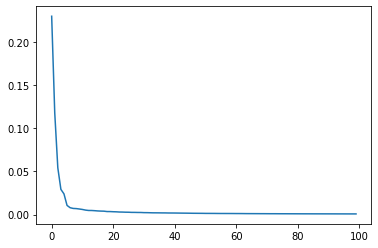

[<matplotlib.lines.Line2D at 0x7f9ac3c64820>]

In [0]:
plt.plot(pipeline.stages[2].explainedVariance)

In [0]:
final_train_df = pipeline.transform(clean_train_df).cache()
final_test_df = pipeline.transform(clean_test_df).cache()

In [0]:
def ml_pipeline(df,
                trainingAlgorithm,
                paramGrid,
                evaluator,
                labels,
                k_fold=5,
                featuresCol='features',
                indexedTargetCol='idx_target',
                predictionCol='prediction',
                rawPredictionCol='rawPrediction',
                labeledPredictionCol='labeled_prediction'):
  
  from pyspark.ml.feature import IndexToString
  from pyspark.ml.tuning import TrainValidationSplit
  from pyspark.ml import Pipeline
  
  trainingAlgorithm = trainingAlgorithm.setFeaturesCol(featuresCol).setLabelCol(indexedTargetCol).setPredictionCol(predictionCol).setRawPredictionCol(rawPredictionCol)
  
  idx2str = IndexToString(inputCol=predictionCol,
                          outputCol=labeledPredictionCol,
                          labels=labels)
  
  ml_pipeline = Pipeline(stages=[trainingAlgorithm, idx2str])
  
  evaluator = evaluator.setLabelCol(indexedTargetCol).setPredictionCol(predictionCol).setMetricName('f1')
  
  return TrainValidationSplit(estimator=ml_pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, collectSubModels=True).fit(df)

In [0]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

nb_classifier = NaiveBayes()
nb_param_grid = ParamGridBuilder().addGrid(nb_classifier.modelType, ['multinomial', 'gaussian']).build()
nb_evaluator = MulticlassClassificationEvaluator()

cv_model = ml_pipeline(final_train_df,
                       nb_classifier,
                       nb_param_grid,
                       nb_evaluator, 
                       ['i', 'e'],
                       featuresCol='idf_features',
                       indexedTargetCol='idx_ie')

In [0]:
print(cv_model.bestModel.stages[0].getModelType())
#cv_model.bestModel.transform(final_test_df).show()
cv_model.getEvaluator().evaluate(cv_model.bestModel.transform(final_test_df))

multinomial
Out[150]: 0.6889300721478958

# Features learning

In [0]:
EMBEDDING_SIZE = 150 # w2v embedding vector size
RANDOM_SEED = 42
layers = [100, 16, 16, 16, 2] # nn layers
#layers = [103, 32, 16, 16, 8, 8, 8, 4, 2] # nn layers
#layers = [103, 312, 208, 208, 104, 104, 52, 52, 32, 32, 8, 8, 2] # nn layers

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline

pipelines = []
for ind in indicators:
  # label to index
  labelIndexer = StringIndexer(inputCol=ind, outputCol=f"idx_{ind}")
  
  # model
  nb = NaiveBayes(featuresCol='idf_features',\
                  labelCol=f'idx_{ind}',\
                  predictionCol=f'pred_{ind}',\
                  modelType='multinomial')
  
  svc = LinearSVC(featuresCol='features',\
                  labelCol=f'idx_{ind}',\
                  predictionCol=f'pred_{ind}')
                  
  
  rf = RandomForestClassifier(featuresCol='features',\
                              labelCol=f'idx_{ind}',\
                              predictionCol=f'pred_{ind}',\
                              seed=RANDOM_SEED)
  
  nn = MultilayerPerceptronClassifier(labelCol=f"idx_{ind}",\
                                      featuresCol="features",\
                                      predictionCol=f"pred_{ind}",\
                                      #rawPredictionCol=f"raw_pred_{ind}",\
                                      #probabilityCol=f'p_{ind}',\
                                      #maxIter=100,\
                                      layers=layers,\
                                      seed=RANDOM_SEED)
  # indexed prediction to label
  labelConverter = IndexToString(inputCol=f"pred_{ind}", outputCol=f"labeled_pred_{ind}", labels=[ind[0], ind[1]])
  pipeline_stages = [
    labelIndexer, 
    nb,
    #rf,
    #svc,
    #nn,
    labelConverter
  ]
  pipelines += [Pipeline(stages=pipeline_stages)]

In [0]:
#models = [pipelines[i].fit(train_dfs[ind]) for i, ind in enumerate(indicators)]
models = []
for i, ind in enumerate(indicators):
  #models.append(PipelineModel.load(f'dbfs:/bdc-2020-21/mbti_project/models/nn_{ind}_big_2906211619'))
  models.append(pipelines[i].fit(final_train_df))
  print(i)

0
1
2
3